# 백테스팅 개발

In [1]:
import xml.etree.ElementTree as elemTree
import os
import sys
tree = elemTree.parse(r'../config/.config.xml')
root = tree.getroot()
xx = root.find('./PATHS')
work_path = xx.find('work').text
sys.path.append(work_path)

In [2]:
import numpy
import talib
from miscs.config_manager import ConfigManager
import pandas as pd
from sqlalchemy import create_engine
from tqdm.auto import tqdm
from realtime_kiwoom.data_provider import *
import re
import numpy as np
import argparse
from miscs.time_manager import TimeManager

c:\Anaconda3\envs\py310_64\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cm = ConfigManager('../config/.config.xml')

# 데이터 로딩

2022-08-01 ~ 2022-09-29일까지만 테스트 하기 위해 최근 90일치를 로딩함

작성 날짜 기준 2022-09-30까지 분봉이 수집되어 있음

In [4]:
history_provider = MinuteChartDataProvider.Factory(cm, tag='history')
history_minute_dic = history_provider.get_history_from_ndays_ago(n_days=90)

In [5]:
action_dic = {'X':'069500', 'Y':'114800'}

날것의 분봉 데이터 조인 및 예측치 로딩

In [6]:
raw_merged_df = pd.merge(history_minute_dic['069500'], history_minute_dic['114800'], left_index=True, right_index=True, how='inner', suffixes=('_X', '_Y'))
y_pred = pd.read_pickle('.y_pred_10m.pkl').rename('decision')

~~y_pred.shift(1)을 하여, t 분의 결정을 t+1 분의 행으로 옮긴다. (시뮬레이션을 편히 하기 위함)~~

In [7]:
raw_merged_df = pd.merge(raw_merged_df, y_pred.rename('action').shift(-1), left_index=True, right_index=True, how='left')
raw_merged_df

,st_code_X,open_X,high_X,low_X,close_X,volume_X,st_code_Y,open_Y,high_Y,low_Y,close_Y,volume_Y,action
dt,,,,,,,,,,,,,
2022-07-11 09:00:00+09:00,069500,31131,31196,31131,31156,44350,114800,4960,4965,4950,4955,922104,NaN
2022-07-11 09:01:00+09:00,069500,31161,31216,31151,31166,57539,114800,4955,4960,4945,4955,764941,NaN
2022-07-11 09:02:00+09:00,069500,31181,31181,31136,31136,28948,114800,4955,4960,4955,4960,321045,NaN
2022-07-11 09:03:00+09:00,069500,31131,31131,31071,31096,42115,114800,4960,4975,4960,4970,790391,NaN
2022-07-11 09:04:00+09:00,069500,31101,31111,31071,31076,14746,114800,4970,4975,4970,4975,845022,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-30 15:16:00+09:00,069500,28250,28250,28235,28240,9289,114800,5455,5455,5450,5455,19328,NaN
2022-09-30 15:17:00+09:00,069500,28245,28245,28235,28240,10281,114800,5455,5455,5450,5450,8836,NaN
2022-09-30 15:18:00+09:00,069500,28240,28245,28210,28215,38230,114800,5455,5460,5450,5455,300579,NaN


# 백테스트 코딩

시뮬레이션 파라미터

- 거래수수로: 매수, 매도시 발생 0.015 % 키움 기준

In [8]:
parser = argparse.ArgumentParser()
parser.add_argument("-i", "--initial_asset", type=float, help="초기애셋", default=10000000)
parser.add_argument("-c", "--commision_rate", type=float, help="거래수수료", default=0.015*0.01)
parser.add_argument("-s", "--slippage_rate", type=float, help="슬리피지", default=0.00)
parser.add_argument("-f", "--from_dt", type=str, help="시작 타임스탬프", default='2022-08-01 09:00:00')
parser.add_argument("-e", "--end_dt", type=str, help="종료 타임스탬프", default='2022-09-29 15:30:00')
args = parser.parse_args(args=[])


In [9]:
class FundSimParams:
  """
  펀드시뮬레이터 파라미터 설정
  """
  def __init__(self, initial_asset, commision_rate, slippage_rate, from_dt, end_dt):
    self.action_dic = {'X': '069500', 'Y': '114800'} # TODO : config.xml에서 가져오기
    self.initial_asset = initial_asset
    self.commision_rate = commision_rate
    self.slippage_rate = slippage_rate
    self.from_dt = TimeManager.str_to_ts(from_dt, '%Y-%m-%d %H:%M:%S')
    self.end_dt = TimeManager.str_to_ts(end_dt, '%Y-%m-%d %H:%M:%S')
 
  @staticmethod
  def tradable_time(dt:pd.Timestamp):
    return dt < TimeManager.ts_floor_time(dt, freq='D') + pd.Timedelta('15:20:00')

  def __repr__(self) -> str:
    return f'initial_asset: {self.initial_asset}, commision_rate: {self.commision_rate}, slippage_rate: {self.slippage_rate}, from_dt: {self.from_dt}, end_dt: {self.end_dt}'

  def __str__(self) -> str:
    return f'initial_asset: {self.initial_asset}, commision_rate: {self.commision_rate}, slippage_rate: {self.slippage_rate}, from_dt: {self.from_dt}, end_dt: {self.end_dt}'

In [10]:
class TradeStock:
  """
  트레이드 정보 저장
  """

  @staticmethod
  def calc_floored_price(price, slippage_rate=0.0, is_ETF=True, is_sell=False):
    """
    ETF의 경우는 5원 단위

    일반 주식의 경우
    그이상: 1000원
    ~500,000: 500원
    ~100,000: 100원
    ~50,000: 50원
    ~10,000: 10원
    ~5,000: 5원
    ~1000: 1원
    """
    if is_sell: # 매도 (슬리피지 만큼 싸게 팔게 됨)
      price = price * (1 - slippage_rate)
    else: # 매수 (슬리피지 만큼 비싸게 사게 됨)
      price = price * (1 + slippage_rate)


    int_price = int(price)
    if is_ETF:
      return (int_price // 5) * 5

    if int_price > 500000:
        return (int_price // 1000) * 1000
    elif int_price > 100000:
        return (int_price // 500) * 500
    elif int_price > 50000:
        return (int_price // 100) * 100
    elif int_price > 10000:
        return (int_price // 50) * 50
    elif int_price > 5000:
        return (int_price // 10) * 10
    elif int_price > 1000:
        return (int_price // 5) * 5
    return int_price


  def __init__(self, suffix='X'):
    self.suffix = suffix
    self.code = None
    self.quantity = 0
    self.buy_dt = None
    self.buy_price = None
    self.buy_step_i = None
    self.cur_step_i = None
    self.cur_dt = None
    self.cur_price = None
    self.sell_dt = None
    self.sell_price = None
    self.sell_step_i = None
    self.buy_transaction_cost = 0
    self.sell_transaction_cost = 0

  def __suffixed(self, what='close'):
    return f'{what}_{self.suffix}'

  def buy(self, df:pd.DataFrame, i:int, available_cash:float, funsim_params:FundSimParams):
    """
    매수
    리턴: 매수를 통해 줄어든 현금 전체
    """
    price = df.iloc[i][self.__suffixed('close')]
    floored_price = TradeStock.calc_floored_price(price, funsim_params.slippage_rate)
    quantity = int(available_cash // floored_price)

    # 매수금액 + 수수료가 예수금을 넘으면 안됨
    if quantity*floored_price* (1+ funsim_params.commision_rate) > available_cash:
      quantity -= 1

    # print(f"{df.iloc[i][self.__suffixed('close')]} -> {price=}, {floored_price=}, {quantity=}")
    self.buy_step_i = i
    self.buy_dt = df.iloc[i].name
    self.buy_price = floored_price
    self.quantity = quantity
    self.code = df.iloc[i][self.__suffixed('st_code')]
    self.buy_transaction_cost = int(quantity * floored_price * funsim_params.commision_rate)
    return int(quantity * floored_price + self.buy_transaction_cost)

  def apply_step(self, df:pd.DataFrame, i:int):
    self.cur_step_i = i
    self.cur_dt = df.iloc[i].name
    self.current_price = df.iloc[i][self.__suffixed('close')]

  def sell(self, df:pd.DataFrame, i:int, funsim_params:FundSimParams):
    """
    매도
    리턴: 매도를 통해 증가한 현금 전체
    """
    price = df.iloc[i][self.__suffixed('close')]
    floored_price = TradeStock.calc_floored_price(price, funsim_params.slippage_rate, is_sell=True)
    self.sell_step_i = i
    self.sell_dt = df.iloc[i].name
    self.sell_price = floored_price
    self.sell_transaction_cost = int(self.quantity * floored_price * funsim_params.commision_rate)
    return int(self.quantity * floored_price - self.sell_transaction_cost)

  def calc_cur_status(self):
    return {
      'suffix':self.suffix,
      'buy_dt':self.buy_dt,
      'cur_dt':self.cur_dt,
      'code': self.code,
      'buy_eval': self.buy_price * self.quantity,
      'cur_eval': self.current_price * self.quantity,
      'buy_tc': self.buy_transaction_cost,
    }

  def calc_result_status(self):
    return {
      'suffix':self.suffix,
      'buy_dt':self.buy_dt,
      'sell_dt':self.sell_dt,
      'code': self.code,
      'buy_eval': self.buy_price * self.quantity,
      'sell_eval': self.sell_price * self.quantity,
      'buy_tc': self.buy_transaction_cost,
      'sell_tc': self.sell_transaction_cost,
    }

  def __repr__(self):
    return str(self.calc_cur_status())

  def __str__(self):
    return str(self.calc_cur_status())




In [11]:
class FundSimulator:
  """
  펀드시뮬레이터
  """
  def __init__(self, fund_sim_params, raw_merged_df):
    self.fund_sim_params = fund_sim_params
    self.raw_merged_df = raw_merged_df
    self.available_cash = fund_sim_params.initial_asset
    self.is_holding = False
    self.trade_stock = None
    self.history_trade_stocks = []
    self.i = -1

    self.__pre_wind_up()

  def __pre_wind_up(self):
    """
    from_dt까지 i를 움직임
    """
    self.i = 0
    while self.raw_merged_df.index[self.i] < self.fund_sim_params.from_dt:
      self.i += 1

  def is_end(self):
    return self.raw_merged_df.iloc[self.i].name >= self.fund_sim_params.end_dt #or np.isnan(self.raw_merged_df.iloc[self.i].action)
    
  def step(self):
    """
    한 스텝 진행
    """
    self.i += 1
    data = self.raw_merged_df.iloc[self.i]
    # print(self.__trade_stock)
    if self.is_holding:
      self.trade_stock.apply_step(self.raw_merged_df, self.i)
      if not FundSimParams.tradable_time(self.raw_merged_df.iloc[self.i].name) or data.action == 'NOP' or data.action == self.trade_stock.suffix:
        return
      else: # 종목체인지
        in_cash = self.trade_stock.sell(self.raw_merged_df, self.i, self.fund_sim_params)
        self.history_trade_stocks.append((self.available_cash, in_cash, self.trade_stock.calc_result_status()))
        # print(self.__trade_stock.calc_result_status())
        self.available_cash += in_cash
        self.is_holding = False
        self.trade_stock=None

    if not self.is_holding:
      if data.action != 'NOP':
        self.is_holding = True
        self.trade_stock = TradeStock(data.action)
        self.trade_stock.apply_step(self.raw_merged_df, self.i)
        out_cash = self.trade_stock.buy(self.raw_merged_df, self.i, self.available_cash, self.fund_sim_params)
        self.available_cash -= out_cash

  def run(self):
    if not self.is_end():
      while True:
        self.step()
        if self.is_end():
          break

  def make_summary(self):
    simulation_summary = pd.DataFrame.from_records(map(lambda x: {
      'fund':x[0]+x[1], 
      'code':x[2]['code'], 
      'buy_dt':x[2]['buy_dt'], 
      'sell_dt':x[2]['sell_dt'],
      'buy_tc':x[2]['buy_tc'],
      'sell_tc':x[2]['sell_tc'],
      'buy_eval':x[2]['buy_eval'],
      'sell_eval':x[2]['sell_eval'],
      }, self.history_trade_stocks))
    simulation_summary.eval("pr = (sell_eval - sell_tc) / (buy_eval + buy_tc) - 1.0", inplace=True)
    simulation_summary['MDD'] = (1 - simulation_summary.fund / simulation_summary.fund.cummax())    
    return simulation_summary



In [12]:
fund_sim_params = FundSimParams(args.initial_asset, args.commision_rate, args.slippage_rate, args.from_dt, args.end_dt)
fund_simulator = FundSimulator(fund_sim_params, raw_merged_df)

시뮬레이션

In [14]:
fund_simulator.run()

요약 데이터프레임 생성

In [15]:
simulation_summary = fund_simulator.make_summary()

In [16]:
simulation_summary

,fund,code,buy_dt,sell_dt,buy_tc,sell_tc,buy_eval,sell_eval,pr,MDD
0,10059872,114800,2022-08-01 15:02:00+09:00,2022-08-02 15:13:00+09:00,1499,1509,9997920,10060800,0.005988,0.000000
1,10058420,069500,2022-08-02 15:13:00+09:00,2022-08-02 15:17:00+09:00,1506,1506,10041720,10043280,-0.000145,0.000144
2,9898303,114800,2022-08-02 15:17:00+09:00,2022-08-08 15:06:00+09:00,1508,1484,10056000,9898875,-0.015920,0.016061
3,10058397,069500,2022-08-08 15:06:00+09:00,2022-08-16 14:58:00+09:00,1481,1505,9876910,10039990,0.016206,0.000147
4,10066204,114800,2022-08-16 14:58:00+09:00,2022-08-16 15:14:00+09:00,1508,1510,10056425,10067250,0.000776,0.000000
...,...,...,...,...,...,...,...,...,...,...
66,10978706,114800,2022-09-26 15:18:00+09:00,2022-09-27 15:09:00+09:00,1637,1646,10918000,10979800,0.005359,0.000000
67,10982999,069500,2022-09-27 15:09:00+09:00,2022-09-27 15:12:00+09:00,1643,1644,10958785,10966365,0.000392,0.000000
68,10969387,114800,2022-09-27 15:12:00+09:00,2022-09-27 15:15:00+09:00,1647,1645,10980480,10970160,-0.001239,0.001239
69,10729888,069500,2022-09-27 15:15:00+09:00,2022-09-28 15:18:00+09:00,1642,1607,10950660,10714410,-0.021867,0.023046


# 결과 분석

fund 추이

<AxesSubplot:xlabel='sell_dt'>

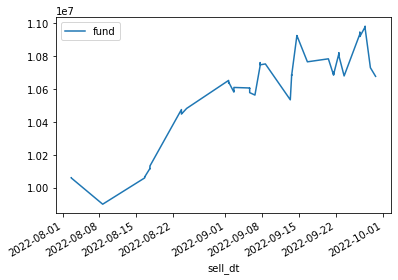

In [17]:
simulation_summary.plot(x='sell_dt', y='fund')

PR 퀀타일

In [18]:
simulation_summary.pr.quantile([0.25, 0.5, 0.75])

0.25   -0.000864
0.50   -0.000134
0.75    0.000977
Name: pr, dtype: float64

MDD

In [19]:
zz = simulation_summary.set_index('sell_dt')

daily_stats = pd.concat((zz.resample('D').buy_eval.first().rename('from'),
            zz.resample('D').sell_eval.last().rename('to'),
            zz.query("code=='069500'").resample('D').code.count().rename('cnt_x'),
            zz.query("code!='069500'").resample('D').code.count().rename('cnt_y'),
            zz.query("code=='069500'").resample('D').pr.mean().rename('avg_pr_x'),
            zz.query("code!='069500'").resample('D').pr.mean().rename('avg_pr_y'),
            ), axis=1).dropna()

<AxesSubplot:xlabel='sell_dt'>

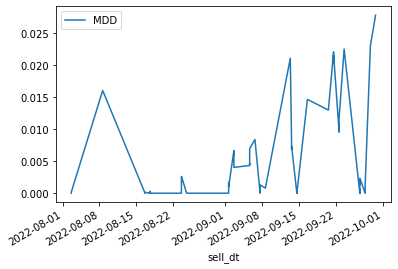

In [20]:
simulation_summary.plot(x='sell_dt', y='MDD')

일별 서머리

  - 일별 최초 매수 (from), 최종 매도 (to) 를 찍은 것임

<AxesSubplot:xlabel='sell_dt'>

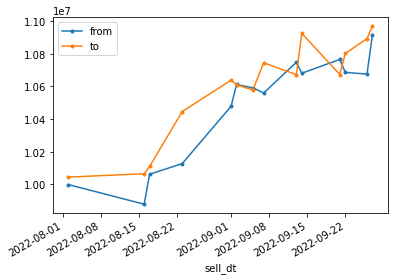

In [21]:
daily_stats[['from', 'to']].plot(style='.-')

일별 서머리
- 일별 x 투자건, y 투자건의 수가 큰 차이 없음

<AxesSubplot:xlabel='sell_dt'>

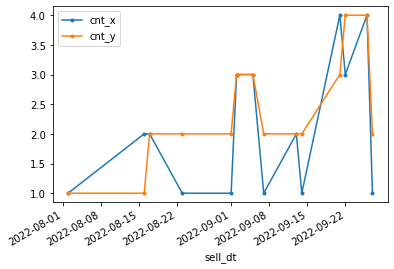

In [22]:
daily_stats[['cnt_x', 'cnt_y']].plot(style='.-')

<AxesSubplot:xlabel='sell_dt'>

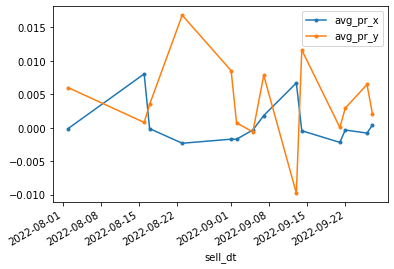

In [23]:
daily_stats[['avg_pr_x', 'avg_pr_y']].plot(style='.-')

# 결론

베이스라인 모델 펀드
- 수익률: 4.88%
  - 거래횟수: 69회
  - 이익거래:손실거래=42:58
  - 수수료 총합: 211,239원 
- MDD 5% 
- 썩 유용하지 않음
- 이익거래 여부 별 거래횟수

|    이익거래 |   code | cnt |
|------:|-------:|-----|
| False | 069500 |  22 |
| False | 114800 |  18 |
|  True | 069500 |  12 |
|  True | 114800 |  17 |

- 이익거래 여부 별 수익률
  
|    이익거래 |   code |    avg_pr |
|------:|-------:|----------:|
| False | 069500 | -0.003575 |
| False | 114800 | -0.004215 |
|  True | 069500 |  0.003268 |
|  True | 114800 |  0.009770 |
  
방향
- 피쳐 추가 및 엔지니어링
- 수익률 히스토리를 피쳐에 반영
- 강화 학습등 학습 방법의 변형

In [24]:
simulation_summary.iloc[-1].fund / fund_sim_params.initial_asset - 1

0.06772540000000005

In [25]:
simulation_summary.eval('buy_tc+sell_tc').sum()

226166

In [26]:
simulation_summary.MDD.max()

0.027838024932898553

In [27]:
simulation_summary.eval("pr < 0").sum() / len(simulation_summary)

0.5070422535211268

In [28]:
simulation_summary.groupby([simulation_summary.pr>0, simulation_summary.code]).fund.count().rename('cnt').reset_index()

,pr,code,cnt
0,False,069500,22
1,False,114800,14
2,True,069500,13
3,True,114800,22


In [29]:
simulation_summary.groupby([simulation_summary.pr>0, simulation_summary.code]).pr.mean().rename('avg_pr').reset_index()

,pr,code,avg_pr
0,False,069500,-0.003484
1,False,114800,-0.003456
2,True,069500,0.002948
3,True,114800,0.007033
